In [94]:
# Computational & Visualisation packages
library(qdap)
library(ggplot2)
library(ggthemes)
library(tm)
library(dplyr)
library(tidyr)
library(wordcloud)

# Suppress warnings
options(warn=-1)

In [95]:
#Subsetting the Dataset
boston_reviews_raw <- read.csv("../data/airbnb_boston_reviews.csv", stringsAsFactors=FALSE)
bos_reviews <- boston_reviews_raw[1:1000, c("id", "comments")]

cat ("A quick look into the dataset \n")
head (bos_reviews)

A quick look into the dataset 


id,comments
4724140,"My stay at islam's place was really cool! Good location, 5min away from subway, then 10min from downtown. The room was nice, all place was clean. Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)"
4869189,Great location for both airport and city - great amenities in the house: Plus Islam was always very helpful even though he was away
5003196,We really enjoyed our stay at Islams house. From the outside the house didn't look so inviting but the inside was very nice! Even though Islam himself was not there everything was prepared for our arrival. The airport T Station is only a 5-10 min walk away. The only little issue was that all the people in the house had to share one bathroom. But it was not really a problem and it worked out fine. We would recommend Islams place for a stay in Boston.
5150351,The room was nice and clean and so were the commodities. Very close to the airport metro station and located in quite safe area. Islam responds very quickly and is very helpful. I would recommend it.
5171140,"Great location. Just 5 mins walk from the Airport Station. Good food nearby. Room was simple, clean, just what I was after."
5198929,"A truely exeptional place to stay. The hosts are amazingly friendly, the rooms are spotless, and there is WiFi. The location is superb: A Latin-American neighborhood close to the airport and just a few subway rides away from downtown. Highly recommened!"


In [96]:
print ("Printing Structure & Dimensions of the dataframe")
print (str(bos_reviews))
cat ("\n")
print (dim(bos_reviews))

[1] "Printing Structure & Dimensions of the dataframe"
'data.frame':	1000 obs. of  2 variables:
 $ id      : int  4724140 4869189 5003196 5150351 5171140 5198929 6702817 6873023 7646702 8094418 ...
 $ comments: chr  "My stay at islam's place was really cool! Good location, 5min away from subway, then 10min from downtown. The r"| __truncated__ "Great location for both airport and city - great amenities in the house: Plus Islam was always very helpful eve"| __truncated__ "We really enjoyed our stay at Islams house. From the outside the house didn't look so inviting but the inside w"| __truncated__ "The room was nice and clean and so were the commodities. Very close to the airport metro station and located in"| __truncated__ ...
NULL

[1] 1000    2


# Examining the Polarity of the dataset

In [97]:
# Summary for all the reviews in the boston dataset
bos_pol <- polarity(bos_reviews$comments)
print (summary(bos_pol$all$polarity))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-0.9467  0.4523  0.7920  0.7735  1.0961  2.7213       3 


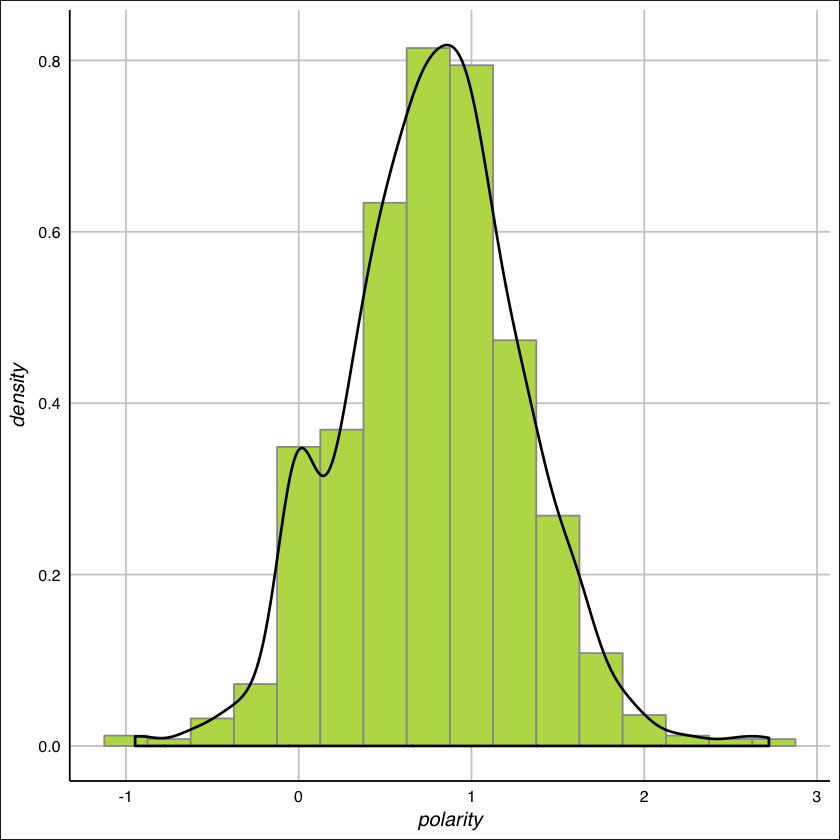

In [98]:
# Visualising the polarity of the reviews
ggplot(bos_pol$all, aes(x = polarity, y = ..density..)) +
  theme_gdocs() + 
  geom_histogram(binwidth = 0.25, fill = "#bada55", colour = "grey60") +
  geom_density(size = 0.75)

## Polarity based corpora Visualisation

In [99]:
bos_reviews_with_pol <- bos_reviews %>% 
  mutate(polarity = bos_pol$all$polarity)

# Subsetting positive and negative comments 
pos_comments <- bos_reviews_with_pol %>% 
  filter(polarity > 0) %>% 
  pull(comments)

neg_comments <- bos_reviews_with_pol %>% 
  filter(polarity < 0) %>% 
  pull(comments)

pos_terms <- paste(pos_comments, collapse = " ")
neg_terms <- paste(neg_comments, collapse = " ")
all_terms <- c(pos_terms, neg_terms)

# Piping a VectorSource Corpus
all_corpus <- all_terms %>% 
  VectorSource() %>% 
  VCorpus()

# Simple TFIDF TDM
all_tdm <- TermDocumentMatrix(
  all_corpus, 
  control = list(
    weighting = weightTfIdf, 
    removePunctuation = TRUE, 
    stopwords = stopwords(kind = "en")
  )
)

# Examining the TDM
all_tdm

<<TermDocumentMatrix (terms: 4385, documents: 2)>>
Non-/sparse entries: 3610/5160
Sparsity           : 59%
Maximal term length: 23
Weighting          : term frequency - inverse document frequency (normalized) (tf-idf)

In [100]:
# Vector to tibble
tidy_reviews <- bos_reviews %>% 
  unnest_tokens(word, comments)

tidy_reviews <- tidy_reviews %>% 
  group_by(id) %>% 
  mutate(original_word_order = seq_along(word))

#tidy_reviews

# Load stopwords
data("stop_words")

# Perform anti-join
tidy_reviews_without_stopwords <- tidy_reviews %>% 
  anti_join(stop_words)

bing <- get_sentiments("bing")

# Calculate polarity for each review
pos_neg <- tidy_reviews %>% 
  inner_join(bing) %>%
  count(sentiment) %>%
  spread(sentiment, n, fill = 0) %>% 
  mutate(polarity = positive - negative)

# Check outcome
summary(pos_neg)

Joining, by = "word"
Joining, by = "word"


       id              negative          positive        polarity      
 Min.   :  146329   Min.   : 0.0000   Min.   : 0.00   Min.   :-12.000  
 1st Qu.:30318834   1st Qu.: 0.0000   1st Qu.: 3.00   1st Qu.:  3.000  
 Median :50612422   Median : 0.0000   Median : 5.00   Median :  4.000  
 Mean   :51931808   Mean   : 0.7265   Mean   : 5.51   Mean   :  4.784  
 3rd Qu.:74945023   3rd Qu.: 1.0000   3rd Qu.: 7.00   3rd Qu.:  6.000  
 Max.   :99951452   Max.   :20.0000   Max.   :23.00   Max.   : 21.000  

Joining, by = "id"


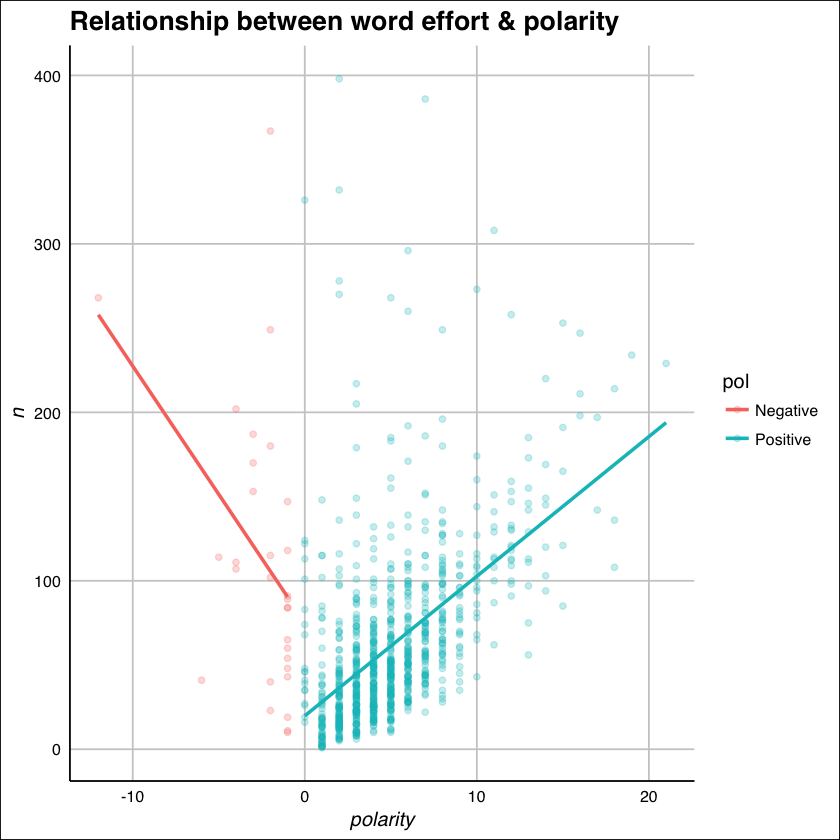

In [101]:
effort <- tidy_reviews %>%
  count(id)
pos_neg_with_effort <- inner_join (pos_neg, effort)

# Adding positive & negative polarity
pos_neg_pol <- pos_neg_with_effort %>%
  mutate(
    pol = ifelse(
      polarity >= 0, 
      "Positive", 
      "Negative"
    )
  )

# Display
ggplot(
  pos_neg_pol, 
  aes(polarity, n, color = pol)
) + 
  geom_point(alpha = 0.25) +
  geom_smooth(method = "lm", se = FALSE) +
  theme_gdocs() +
  ggtitle("Relationship between word effort & polarity")

## Comparison Cloud

In [102]:
all_tdm_m <- as.matrix(all_tdm)
colnames(all_tdm_m) <- c("positive", "negative")

order_by_pos <- order(all_tdm_m[, 1], decreasing = TRUE) #Order from highest to least
all_tdm_m[order_by_pos, ] %>% head(n=10) #Subsetting 10 most frequent positive words

order_by_neg <- order(all_tdm_m[,2], decreasing = TRUE) #Order from highest to least
all_tdm_m[order_by_neg, ] %>% head(n=10) #Subsetting 10 most frequent negative words


,positive,negative
quiet,0.002998112,0
subway,0.002924085,0
walking,0.002887071,0
thanks,0.002813044,0
enjoyed,0.002702002,0
alex,0.002590961,0
restaurants,0.002590961,0
little,0.002516934,0
wonderful,0.002442906,0
amazing,0.002220824,0


,positive,negative
het,0,0.003855050
war,0,0.002313030
für,0,0.001927525
een,0,0.001542020
era,0,0.001542020
mich,0,0.001542020
aufenthalt,0,0.001156515
dat,0,0.001156515
departamento,0,0.001156515
deux,0,0.001156515


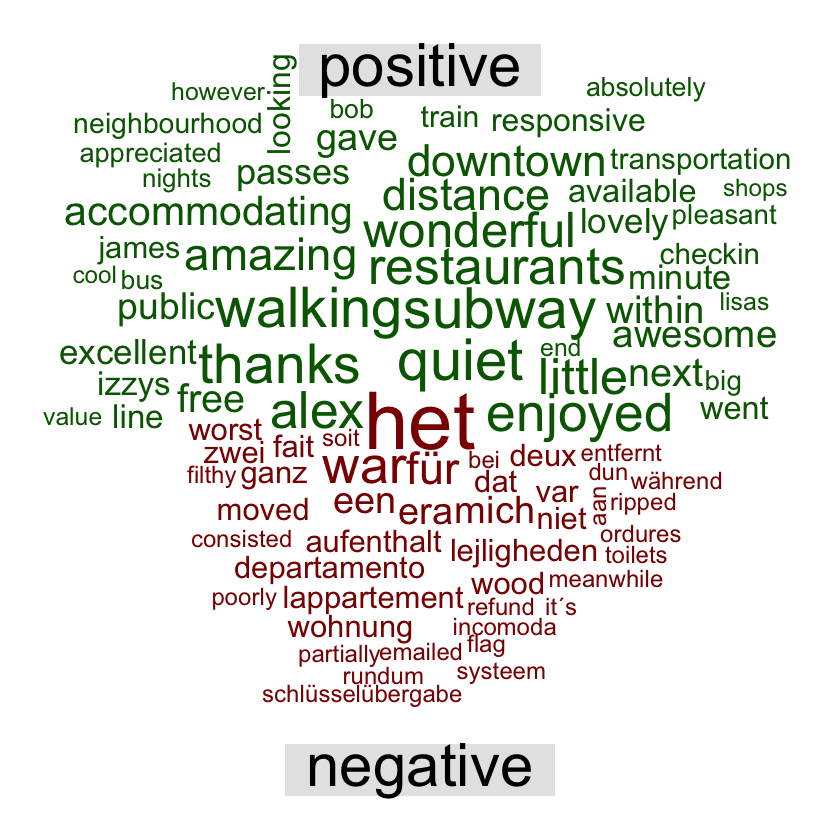

In [103]:
# Comparison cloud
comparison.cloud(
  all_tdm_m, 
  max.words = 90,
  colors = c("darkgreen","darkred")
)

## Scaled comparison cloud

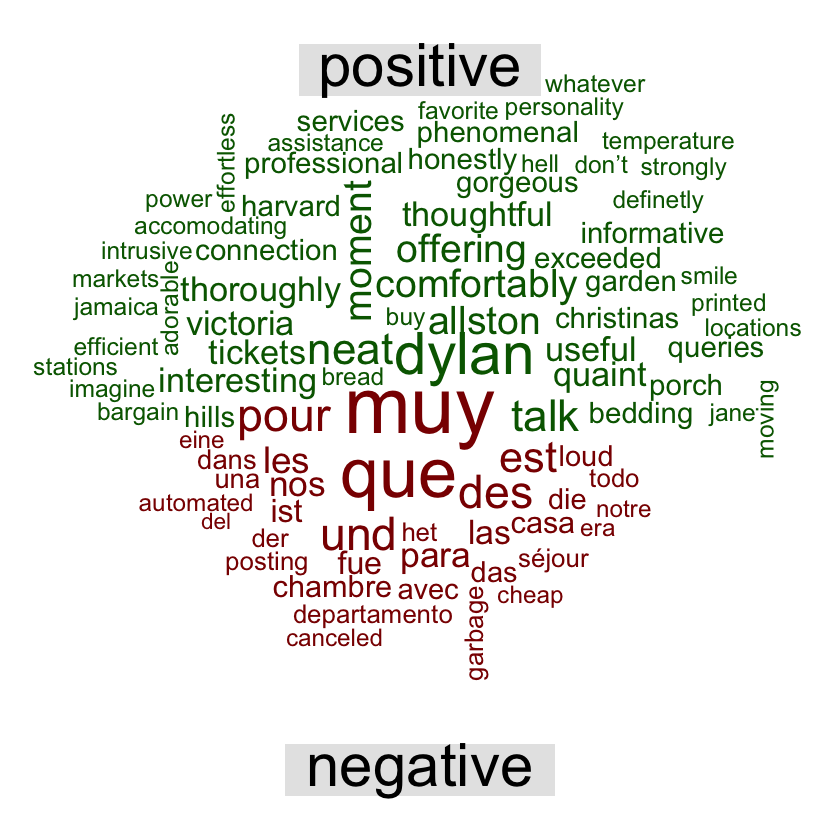

In [104]:
bos_reviews$scaled_polarity <- scale(bos_pol$all$polarity)

pos_comments <- subset(bos_reviews$comments, bos_reviews$scaled_polarity>0)
neg_comments <- subset(bos_reviews$comments, bos_reviews$scaled_polarity<0)

pos_terms <- paste(pos_comments, collapse = " ")
neg_terms <- paste(neg_comments, collapse = " ")
all_terms<- c(pos_terms, neg_terms)

all_corpus <- VCorpus(VectorSource(all_terms))

all_tdm <- TermDocumentMatrix(
  all_corpus, 
  control = list(
    weighting = weightTfIdf, 
    removePunctuation = TRUE, 
    stopwords = stopwords(kind = "en")
  )
)

all_tdm_m <- as.matrix(all_tdm)
colnames(all_tdm_m) <- c("positive", "negative")

# Comparison cloud
comparison.cloud(
  all_tdm_m, 
  max.words = 90,
  colors = c("darkgreen", "darkred")
)